# 🔄 Acquisition, Retention & Churn Analysis

## Executive Summary
This notebook analyzes the lifecycle of the player base, segmented by our behavioral personas.

**Key Dimensions:**
1.  **Acquisition**: Where are new players coming from (Entry Games) and how is the mix of "Whales" vs. "Casuals" changing over time?
2.  **Retention (Cohort Analysis)**: Do High Rollers stick around longer than Casuals? We use classic Cohort Heatmaps to visualize this.
3.  **Churn Risk**: Which games have the highest "One-and-Done" rate?

**Data Sources:**
* `transactions_bronze`: Financial logs.
* `players_clustered`: Behavioral Segments.
* `games_bronze`: Game metadata (joined for "Per Game" analysis).

In [0]:
#python imports_and_config magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, min, max, date_trunc, datediff, countDistinct, lit, when, months_between

# Set vivid plotting theme
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("tab10") # Vivid, distinct colors

def show_plot():
    plt.show()

## 1. Data Loading & Preparation
We join transactions with clusters and game metadata. We also calculate the **"First Seen Date"** for every player to establish their Cohort.

In [0]:
from pyspark.sql.functions import col, min, date_trunc

# 1. Load Tables
df_clusters = spark.table("casino_ctg.log_db.players_clustered")
df_trans = spark.table("casino_ctg.log_db.transactions_bronze")
df_games = spark.table("casino_ctg.log_db.games_bronze")

# 2. Join Transactions + Clusters
df_base = df_trans.join(df_clusters, on="player_id", how="inner")

# 3. Join Games (Left join)
# We select df_base["*"] and ONLY the new columns from df_games (type)
# We exclude df_games["game_id"] to avoid "Ambiguous Reference" errors since it is already in df_base
df_joined = df_base.join(df_games, on="game_id", how="left") \
                   .select(df_base["*"], df_games["type"])

# 4. Calculate Player Cohorts using 'date' (Earliest date a player was seen)
player_cohorts = df_joined.groupBy("player_id").agg(min("date").alias("first_seen"))

# 5. Add Cohort info back to main DataFrame
# We calculate cohort_month based on the 'first_seen' date
df_full = df_joined.join(player_cohorts, on="player_id", how="inner") \
                   .withColumn("cohort_month", date_trunc("month", col("first_seen")))

print(f"Total Rows: {df_full.count():,}")
# Displaying timestamp as requested in your snippet
display(df_full.select("player_id", "label", "game_id", "cohort_month", "timestamp").limit(5))

Total Rows: 16,847,373


player_id,label,game_id,cohort_month,timestamp
P000002,🎲 Risk Taker,G002,2024-05-01T00:00:00.000Z,2024-08-02T21:23:00.000Z
P000002,🎲 Risk Taker,G002,2024-05-01T00:00:00.000Z,2024-08-02T21:23:10.404Z
P000002,🎲 Risk Taker,G002,2024-05-01T00:00:00.000Z,2024-08-02T21:23:43.478Z
P000002,🎲 Risk Taker,G002,2024-05-01T00:00:00.000Z,2024-08-02T21:24:29.768Z
P000002,🎲 Risk Taker,G002,2024-05-01T00:00:00.000Z,2024-08-02T21:24:54.254Z


## 2. Acquisition Analysis
### A. New Player Acquisition by Persona (Stacked Bar)
Are we acquiring more Whales or Casuals over time?

/databricks/python/lib/python3.11/site-packages/seaborn/distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127958 (\N{BEACH WITH UMBRELLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure

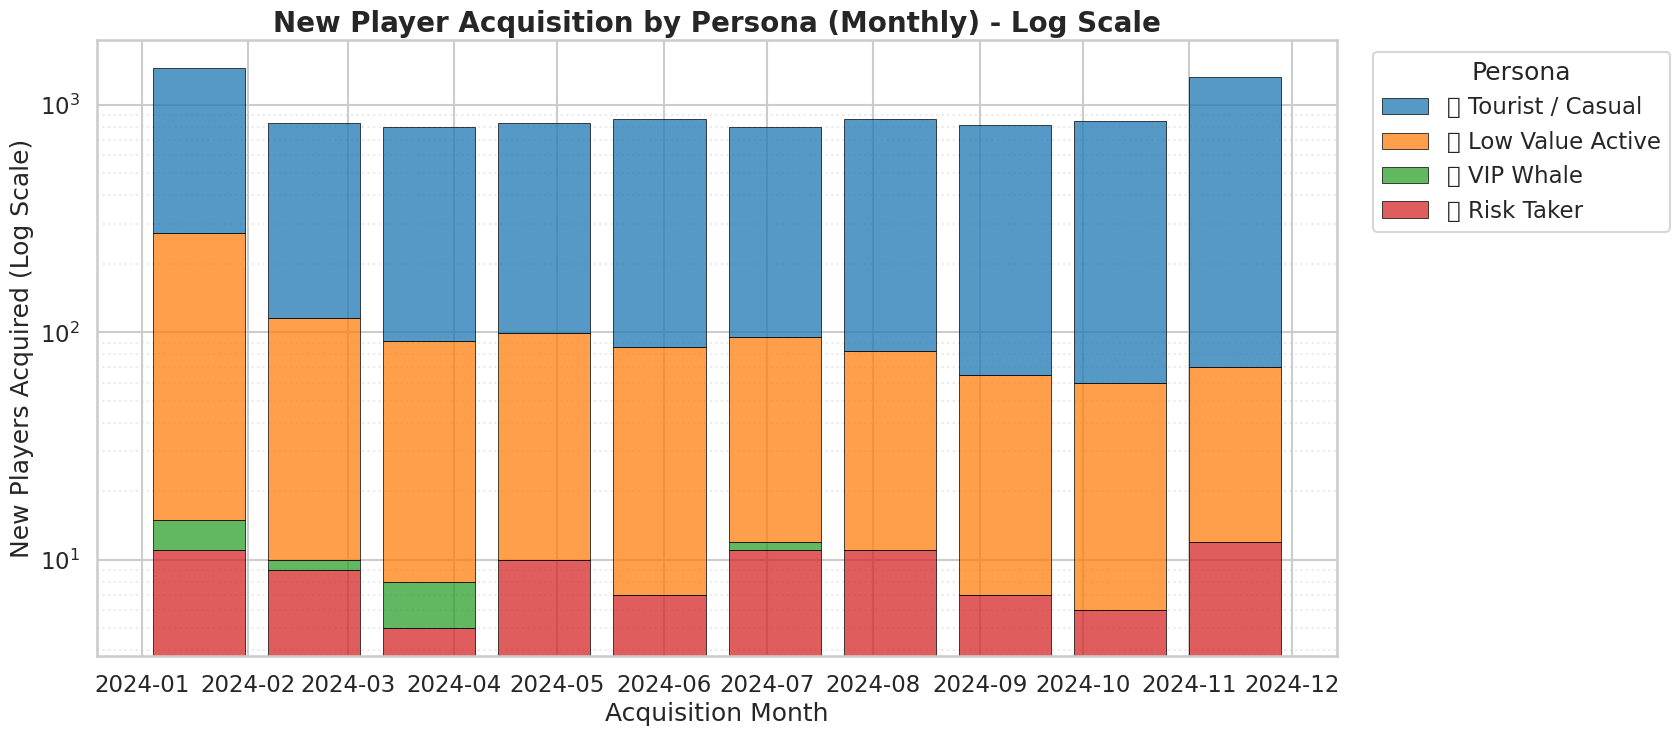

In [0]:
# Aggregating New Players per Month by Label
acquisition_spark = df_full.select("player_id", "cohort_month", "label") \
                           .distinct() \
                           .groupBy("cohort_month", "label") \
                           .count() \
                           .orderBy("cohort_month")

acq_df = acquisition_spark.toPandas()

# Visualization: Stacked Bar Chart
plt.figure(figsize=(16, 8))

# Capture the axes object (ax) to manipulate the legend
ax = sns.histplot(data=acq_df, x="cohort_month", weights="count", hue="label", 
                  multiple="stack", palette="tab10", shrink=0.8, 
                  edgecolor="black", linewidth=0.5) # linewidth makes the stacks distinct

# --- FIX 1: Log Scale ---
plt.yscale('log')

# --- FIX 2: Legend Handling ---
# Removing plt.legend() prevents the "empty box" error.
# We move the built-in Seaborn legend to the side.
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1), title="Persona")

plt.title("New Player Acquisition by Persona (Monthly) - Log Scale", fontsize=20, fontweight='bold')
plt.ylabel("New Players Acquired (Log Scale)")
plt.xlabel("Acquisition Month")

# Handle Y-axis limit to prevent log(0) issues if counts are small
plt.grid(True, which="minor", axis="y", linestyle=":", alpha=0.4)
show_plot()

### B. "Entry Game" Analysis
Which games act as the best "Recruitment Tools" for high-value players?
We look at the **first game** played by VIP Whales.

game_id,count
G003,4581
G004,2211
G002,1631


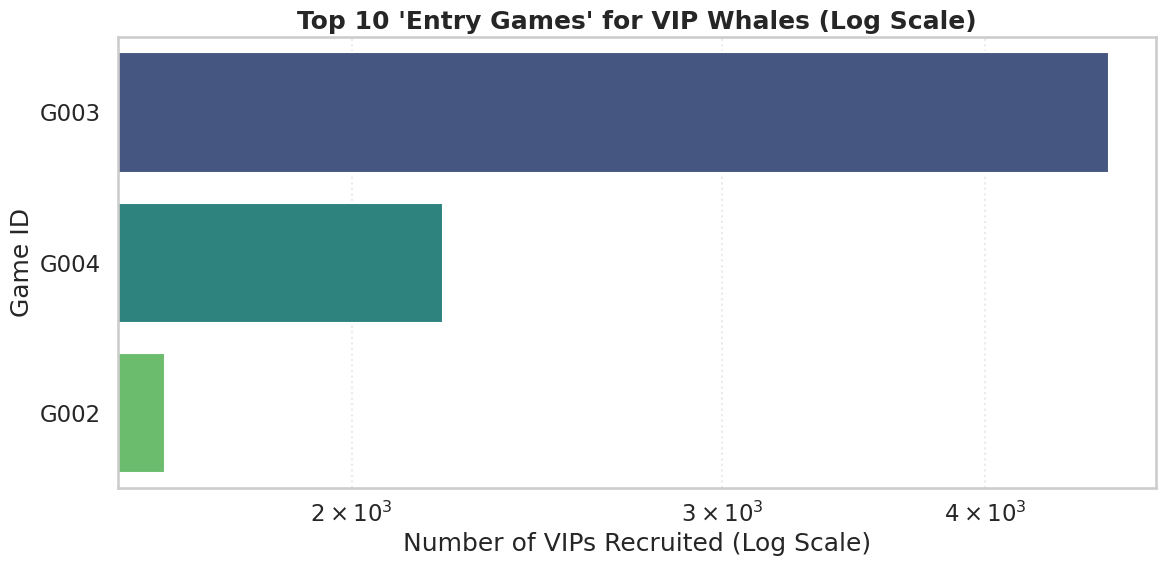

In [0]:
# Filter for the very first transaction of VIPs
entry_games_spark = df_full.filter(
    (col("date") == col("first_seen")) & 
    (col("label").contains("Whale"))
).groupBy("game_id").count().orderBy("count", ascending=False).limit(10)

entry_df = entry_games_spark.toPandas()

# FIX 1: Convert game_id to string to force categorical plotting (prevents bars disappearing)
entry_df["game_id"] = entry_df["game_id"].astype(str)
display(entry_df)


plt.figure(figsize=(12, 6))

# FIX 2: Log Scale on X-axis & Order
# We assume the user wants to see the IDs ranked 1-10, so we pass 'order'
sns.barplot(data=entry_df, y="game_id", x="count", palette="viridis", 
            order=entry_df["game_id"])

plt.xscale('log')

plt.title("Top 10 'Entry Games' for VIP Whales (Log Scale)", fontsize=18, fontweight='bold')
plt.xlabel("Number of VIPs Recruited (Log Scale)")
plt.ylabel("Game ID")
plt.grid(True, which="minor", axis="x", linestyle=":", alpha=0.4)
plt.tight_layout()
show_plot()

## 3. Retention Analysis (Cohorts)
We calculate the **Retention Rate**: The percentage of a cohort that returns to play in subsequent months.

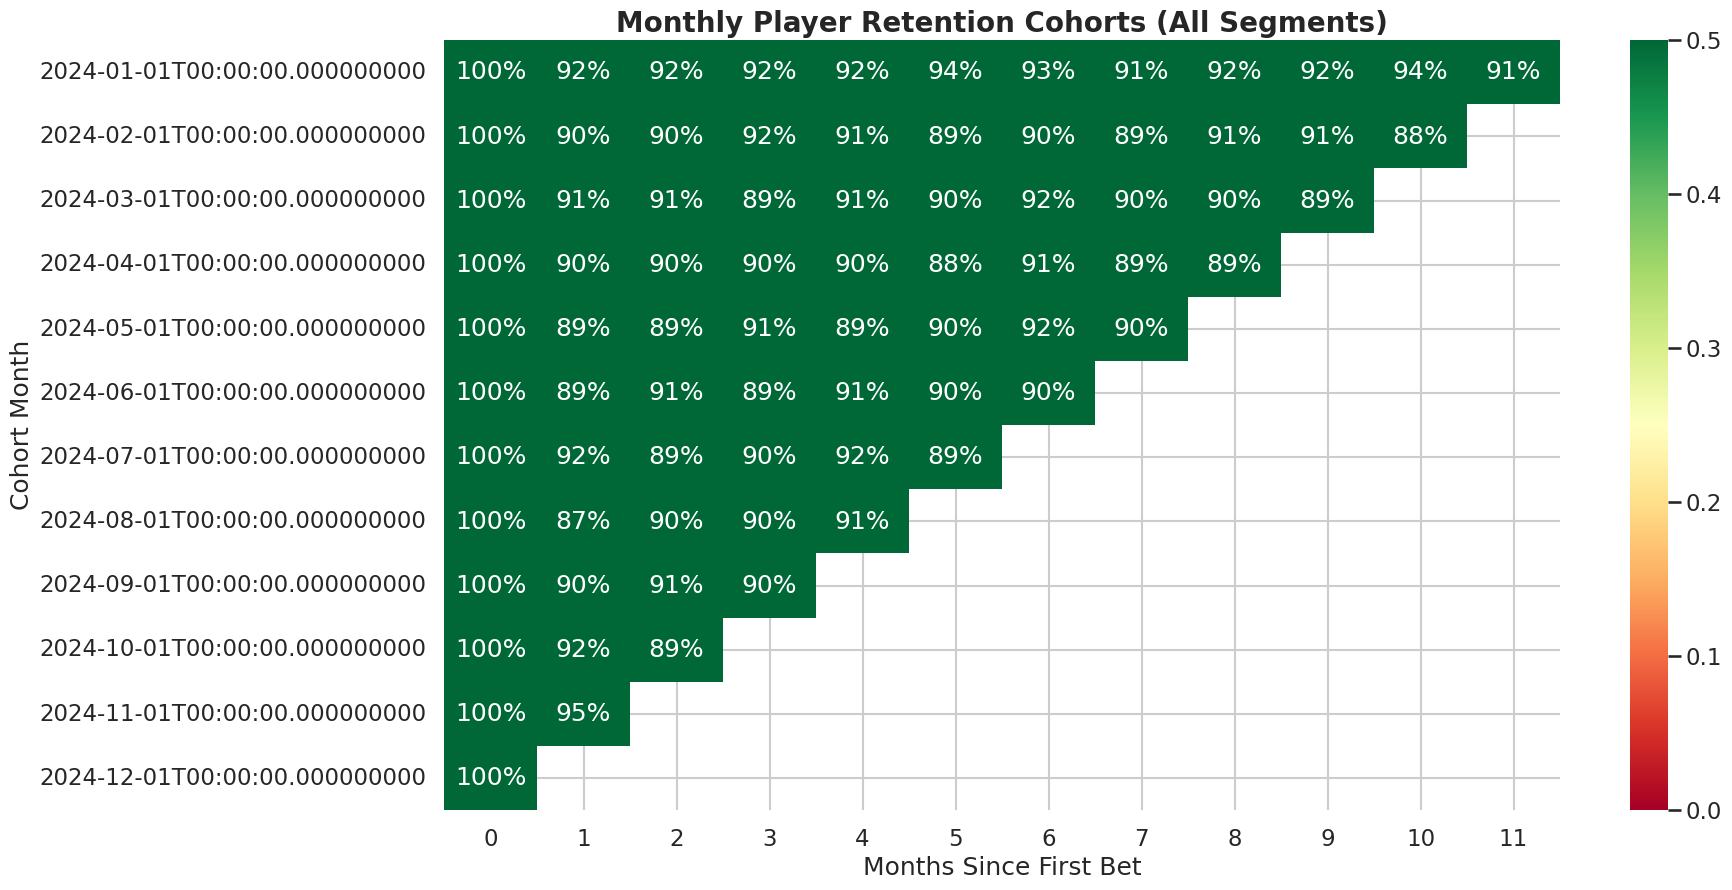

In [0]:
# 1. Calculate Months Since First Seen for every transaction
df_retention = df_full.withColumn(
    "months_active", 
    months_between(date_trunc("month", col("date")), col("cohort_month")).cast("int")
)

# 2. Group by Cohort + Months Active to get retention counts
cohort_counts = df_retention.groupBy("cohort_month", "months_active") \
                            .agg(countDistinct("player_id").alias("active_users")) \
                            .orderBy("cohort_month", "months_active")

# 3. Get Cohort Sizes (Month 0 count) to normalize
cohort_sizes = cohort_counts.filter(col("months_active") == 0) \
                            .withColumnRenamed("active_users", "cohort_size") \
                            .select("cohort_month", "cohort_size")

# 4. Join and Calculate Percentage
retention_final = cohort_counts.join(cohort_sizes, on="cohort_month", how="inner") \
                               .withColumn("retention_rate", col("active_users") / col("cohort_size"))

retention_matrix = retention_final.toPandas().pivot(
    index="cohort_month", columns="months_active", values="retention_rate"
)

# Visualization: The Classic Triangle Heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='RdYlGn', vmin=0.0, vmax=0.5)
plt.title("Monthly Player Retention Cohorts (All Segments)", fontsize=20, fontweight='bold')
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Bet")
show_plot()

### B. Retention Curves by Persona
Does the "Grinder" segment actually retain better than the "High Roller"?

/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127958 (\N{BEACH WITH UMBRELLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


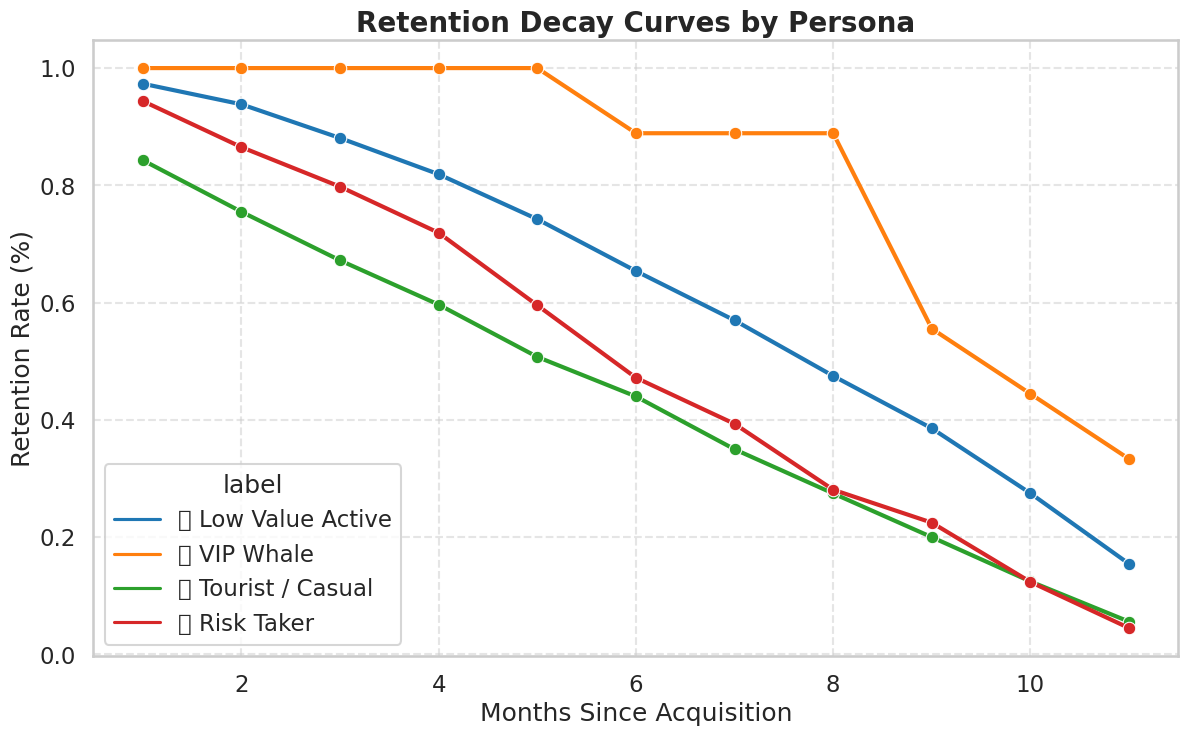

In [0]:
# Similar calc, but grouping by Label as well
persona_retention = df_retention.groupBy("label", "months_active") \
                                .agg(countDistinct("player_id").alias("active_users"))

# Get totals per persona (Month 0)
persona_totals = persona_retention.filter(col("months_active") == 0) \
                                  .withColumnRenamed("active_users", "total_users") \
                                  .select("label", "total_users")

persona_ret_pct = persona_retention.join(persona_totals, on="label") \
                                   .withColumn("retention_pct", col("active_users") / col("total_users")) \
                                   .filter(col("months_active") > 0) \
                                   .filter(col("months_active") <= 12) # Focus on first year

plot_data = persona_ret_pct.toPandas().sort_values("months_active")

plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data, x="months_active", y="retention_pct", hue="label", 
             linewidth=3, marker='o', palette="tab10")

plt.title("Retention Decay Curves by Persona", fontsize=20, fontweight='bold')
plt.ylabel("Retention Rate (%)")
plt.xlabel("Months Since Acquisition")
plt.grid(True, linestyle='--', alpha=0.5)
show_plot()

## 4. Churn Risk Analysis (Per Game)
Which games have the highest **"One-and-Done" rate**? (Players who played this game once and churned immediately).

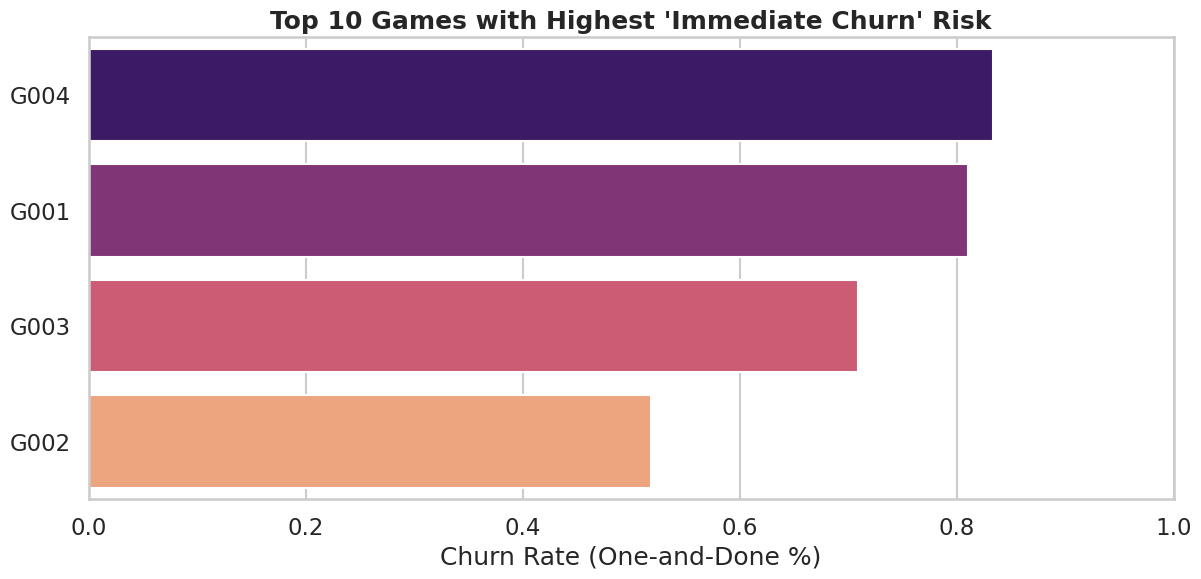

In [0]:
from pyspark.sql.functions import count, sum as _sum

# Definition: A player is "One-and-Done" if they have only 1 total session
# We aggregate by Entry Game

churn_stats = df_full.filter(col("date") == col("first_seen")) \
                     .groupBy("game_id") \
                     .agg(
                         count("player_id").alias("total_starts"),
                         # If the user is in cluster 'Tourist' or 'Casual' (One time), count them
                         # Note: Adjust string match to your specific labels
                         _sum(when(col("label").contains("Tourist"), 1).otherwise(0)).alias("churned_players")
                     ) \
                     .withColumn("churn_rate", col("churned_players") / col("total_starts")) \
                     .filter(col("total_starts") > 50).orderBy("churn_rate", ascending=False).limit(10)

churn_df = churn_stats.toPandas()

plt.figure(figsize=(14, 6))
sns.barplot(data=churn_df, x="churn_rate", y="game_id", palette="magma")
plt.title("Top 10 Games with Highest 'Immediate Churn' Risk", fontsize=18, fontweight='bold')
plt.xlabel("Churn Rate (One-and-Done %)")
plt.ylabel("")
plt.xlim(0, 1)
show_plot()